# Conformalized quantile regression (CQR): Library dataset experiment

In this tutorial we will load the library dataset and construct prediction intervals using CQR [1].

[1] Yaniv Romano, Evan Patterson, and Emmanuel J. Candes, “Conformalized quantile regression.” 2019.

## Prediction intervals

Suppose we are given $ n $ training samples $ \{(X_i, Y_i)\}_{i=1}^n$ and we must now predict the unknown value of $Y_{n+1}$ at a test point $X_{n+1}$. We assume that all the samples $ \{(X_i,Y_i)\}_{i=1}^{n+1} $ are drawn exchangeably$-$for instance, they may be drawn i.i.d.$-$from an arbitrary joint distribution $P_{XY}$ over the feature vectors $ X\in \mathbb{R}^p $ and response variables $ Y\in \mathbb{R} $. We aim to construct a marginal distribution-free prediction interval $C(X_{n+1}) \subseteq \mathbb{R}$ that is likely to contain the unknown response $Y_{n+1} $. That is, given a desired miscoverage rate $ \alpha $, we ask that
$$ \mathbb{P}\{Y_{n+1} \in C(X_{n+1})\} \geq 1-\alpha $$
for any joint distribution $ P_{XY} $ and any sample size $n$. The probability in this statement is marginal, being taken over all the samples $ \{(X_i, Y_i)\}_{i=1}^{n+1} $.

To accomplish this, we build on the method of split conformal prediction. We first split the training data into two disjoint subsets, a proper training set and a calibration set. We fit two quantile regressors on the proper training set to obtain initial estimates of the lower and upper bounds of the prediction interval. Then, using the calibration set, we conformalize and, if necessary, correct this prediction interval. Unlike the original interval, the conformalized prediction interval is guaranteed to satisfy the coverage requirement regardless of the choice or accuracy of the quantile regression estimator.



## A case study

We start by importing several libraries, loading the real dataset and standardize its features and response. We set the target miscoverage rate $\alpha$ to 0.1.

In [8]:
# !pip install torch
# !pip install Scikit-garden
# !pip install --upgrade scikit-learn==0.20.3
# !pip install Scikit-garden
# !pip install --upgrade scikit-learn==0.20.3

In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import category_encoders as ce

## Generate lags for all input features, re-generate even if some exist so that order will not be shuffled after nan dropping
def generate_lags_for(df, column, lags_count):
        for i in range(lags_count):
            lag_name = column + "-" + str(i + 1)
            df[lag_name] = df[column].shift(i + 1)
        return df

def generate_lags(df, lagsForColumns):
    '''This function generates the lags for the list of columns'''
    for k in range(len(lagsForColumns)):
        col = lagsForColumns[k]
        if col in df.columns:
            df = generate_lags_for(df, col, 5)
    return df

def binary_encode_column(df, columnToEncode):
    encoder = ce.BinaryEncoder(cols=[columnToEncode])
    df_encoder = encoder.fit_transform(df[columnToEncode])
    df = pd.concat([df, df_encoder], axis=1)
    return df


def split_train_test_valid(df, TRAIN_RATIO, TEST_RATIO):
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    Y_train = pd.DataFrame()
    Y_test = pd.DataFrame()
    unique_sites = df["Site"].unique()
    print("Number of sites:", len(unique_sites))

    for site in unique_sites:
        df_site = df[df["Site"] == site]
        X = df_site
        train_index = int(X.shape[0] * TRAIN_RATIO)
        test_index = int(X.shape[0] * (TRAIN_RATIO + TEST_RATIO))

        X_train = X_train.append(X[:train_index], ignore_index = True)
        X_test = X_test.append(X[train_index:], ignore_index = True)
        Y_train = Y_train.append(X[:train_index], ignore_index = True)
        Y_test = Y_test.append(X[train_index:], ignore_index = True)

    Y_train = Y_train[[output_column]]
    Y_test = Y_test[[output_column]]
   
    X_train = X_train.drop([output_column], axis = 1)
    X_test = X_test.drop([output_column], axis = 1)
   
    return X_train, X_test, Y_train, Y_test

def GetDataset(name, base_path):
    """ Load a dataset
    
    Parameters
    ----------
    name : string, dataset name
    base_path : string, e.g. "path/to/datasets/directory/"
    
    Returns
    -------
    X : features (nXp)
    y : labels (n)
    
    """
    
    if name=="library":
        
        #Library
        output_column = 'LE_bowen_corr_mm'
        columnsToDrop = ['Year','Month','Day','Latitude','Longitude',
                         'Climate','Vegetation', 'G','G-1','G-2','G-3','G-4','G-5',
                         'H','H_bowen_corr','H_bowen_corr-1','H_bowen_corr-2','H_bowen_corr-3',
                         'H_bowen_corr-4','H_bowen_corr-5', 'H_ebr_corr','H_ebr_corr-1','H_ebr_corr-2',
                         'H_ebr_corr-3','H_ebr_corr-4','H_ebr_corr-5','LE_ebr_corr',
                         'ET_bowen','ET_bowen_corr','ET_ebr','ET_ebr_corr',
                         'ET_ebr_corr(mm)' ,'NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4',
                         'NETRAD-5','LE','LE_bowen_corr','EToF_bowen','EToF_ebr',
                         'ETr','ETrF_bowen','ETrF_ebr', 'Climate_1',
                         'Climate_2','Climate_3', 'Latitude_1', "SW_IN",
                         'Latitude_2','Latitude_3','Latitude_4','Latitude_5','Latitude_6', 'Longitude_1',
                         'Longitude_2','Longitude_3','Longitude_4','Longitude_5','Longitude_6',
                         'Elevation(m)_1','Elevation(m)_2','Elevation(m)_3','Elevation(m)_4',
                         'Elevation(m)_5','Elevation(m)_6', 'NETRAD', 'LE_ebr_corr(mm)', 'Site_1', 'Site_2', 'Site_3', 'Site_4', 'Site_5',
                         'Site_6', 'ET_bowen_corr_mm', 'ETo'
                         ]  
        
        df=pd.read_csv(base_path)
        #set output variable between 1 and 15 only
        df = df[df[output_column].between(1, 15)]
        #df.rename(columns_rename, inplace=True)

        #drop desired columns, rename, and drop the nans
        df = df.drop(columnsToDrop, axis = 1)
        df.dropna(inplace=True)

        #generate lags for columns
        lagsForColumns = ["WS", "RH", "TA", "Eeflux_LST", "Eeflux_Albedo", "Eeflux_NDVI", "SW_IN"]
        df = generate_lags(df, lagsForColumns)

        df = binary_encode_column(df, "Site")
        df.drop(columns=['Site_0'], inplace=True)

        #drop nan for the first 5 rows of the generated lags only 5 rows will be removed in here
        df.isnull().mean() * 10
        df.dropna(inplace=True)
        print(df.shape)
        print("checking null values in the whole dataset")
        print(df.isnull().values.any())
        print(df.columns)
        #df[output_column] = df['ET_bowen_corr_mm'] / df['ETo']
        #df = df.drop(['ET_bowen_corr_mm', 'ETo'], axis=1)
        df.dropna(inplace=True)
        X = df.drop(['LE_bowen_corr_mm', "Date"], axis = 1)
        y = df['LE_bowen_corr_mm']
        
        
        
    if name=="library_reg_split":
        
        #Library
        output_column = 'LE_bowen_corr_mm'
        columnsToDrop = ['Year','Month','Day','Latitude','Longitude',
                         'Climate','Vegetation', 'G','G-1','G-2','G-3','G-4','G-5',
                         'H','H_bowen_corr','H_bowen_corr-1','H_bowen_corr-2','H_bowen_corr-3',
                         'H_bowen_corr-4','H_bowen_corr-5', 'H_ebr_corr','H_ebr_corr-1','H_ebr_corr-2',
                         'H_ebr_corr-3','H_ebr_corr-4','H_ebr_corr-5','LE_ebr_corr',
                         'ET_bowen','ET_bowen_corr','ET_ebr','ET_ebr_corr',
                         'ET_ebr_corr(mm)' ,'NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4',
                         'NETRAD-5','LE','LE_bowen_corr','EToF_bowen','EToF_ebr',
                         'ETr','ETrF_bowen','ETrF_ebr', 'Climate_1',
                         'Climate_2','Climate_3', 'Latitude_1', "SW_IN",
                         'Latitude_2','Latitude_3','Latitude_4','Latitude_5','Latitude_6', 'Longitude_1',
                         'Longitude_2','Longitude_3','Longitude_4','Longitude_5','Longitude_6',
                         'Elevation(m)_1','Elevation(m)_2','Elevation(m)_3','Elevation(m)_4',
                         'Elevation(m)_5','Elevation(m)_6', 'NETRAD', 'LE_ebr_corr(mm)', 'Site_1', 'Site_2', 'Site_3', 'Site_4', 'Site_5',
                         'Site_6', 'ET_bowen_corr_mm', 'ETo'
                         ]  
        
        df=pd.read_csv(base_path)
        #set output variable between 1 and 15 only
        df = df[df[output_column].between(1, 15)]
        #df.rename(columns_rename, inplace=True)

        #drop desired columns, rename, and drop the nans
        df = df.drop(columnsToDrop, axis = 1)
        df.dropna(inplace=True)

        #generate lags for columns
        lagsForColumns = ["WS", "RH", "TA", "Eeflux_LST", "Eeflux_Albedo", "Eeflux_NDVI", "SW_IN"]
        df = generate_lags(df, lagsForColumns)

        df = binary_encode_column(df, "Site")
        df.drop(columns=['Site_0'], inplace=True)

        #drop nan for the first 5 rows of the generated lags only 5 rows will be removed in here
        df.isnull().mean() * 10
        df.dropna(inplace=True)
        print(df.shape)
        print("checking null values in the whole dataset")
        print(df.isnull().values.any())
        print(df.columns)
        #df[output_column] = df['ET_bowen_corr_mm'] / df['ETo']
        #df = df.drop(['ET_bowen_corr_mm', 'ETo'], axis=1)
        df.dropna(inplace=True)
        X = df.drop(['LE_bowen_corr_mm', "Date", "Site"], axis = 1)
        y = df['LE_bowen_corr_mm']
        X = X.astype(np.float32)
        y = y.astype(np.float32)


    return X, y, df

In [2]:
import torch
import random
import numpy as np
np.warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

seed = 1

output_column = 'LE_bowen_corr_mm'

random_state_train_test = seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
# desired miscoverage error
alpha = 0.1

# desired quanitile levels
quantiles = [0.05, 0.95]

# used to determine the size of test set
test_ratio = 0.2

# name of dataset
dataset_base_path = "/apps/data/Library_Daily_Albedo_NDVI_LST_Cleaned.csv"
dataset_name = "library"

# load the dataset
X, y, df = GetDataset(dataset_name, dataset_base_path)

# divide the dataset into test and train based on the test_ratio parameter
x_train, x_test, y_train, y_test = split_train_test_valid(df, 1-test_ratio, test_ratio)
columnToDrop = ["Site", "Date"]
x_train.drop(columnToDrop, axis = 1, inplace=True)
x_test.drop(columnToDrop, axis = 1, inplace=True)
df.drop(columnToDrop, axis = 1, inplace=True)

# reshape the data
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

# compute input dimensions
n_train = x_train.shape[0]
in_shape = x_train.shape[1]

# display basic information
print("Dataset: %s" % (dataset_name))
print("Dimensions: train set (n=%d, p=%d) ; test set (n=%d, p=%d)" % 
      (x_train.shape[0], x_train.shape[1], x_test.shape[0], x_test.shape[1]))

(5123, 51)
checking null values in the whole dataset
False
Index(['Date', 'Site', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Vegetation_1', 'Vegetation_2', 'Vegetation_3', 'WS', 'WS-1', 'WS-2',
       'WS-3', 'WS-4', 'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5',
       'TA', 'TA-1', 'TA-2', 'TA-3', 'TA-4', 'TA-5', 'LE_bowen_corr_mm',
       'Eeflux_LST', 'Eeflux_LST-1', 'Eeflux_LST-2', 'Eeflux_LST-3',
       'Eeflux_LST-4', 'Eeflux_LST-5', 'Eeflux_NDVI', 'Eeflux_NDVI-1',
       'Eeflux_NDVI-2', 'Eeflux_NDVI-3', 'Eeflux_NDVI-4', 'Eeflux_NDVI-5',
       'Eeflux_Albedo', 'Eeflux_Albedo-1', 'Eeflux_Albedo-2',
       'Eeflux_Albedo-3', 'Eeflux_Albedo-4', 'Eeflux_Albedo-5', 'Site_1',
       'Site_2', 'Site_3', 'Site_4', 'Site_5'],
      dtype='object')
Number of sites: 24
Dataset: library
Dimensions: train set (n=4090, p=48) ; test set (n=1033, p=48)


## Data splitting

We begin by splitting the data into a proper training set and a calibration set. Recall that the main idea is to fit a regression model on the proper training samples, then use the residuals on a held-out validation set to quantify the uncertainty in future predictions.

In [3]:
# divide the data into proper training set and calibration set
idx = np.random.permutation(n_train)
n_half = int(np.floor(n_train/2))
idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

# zero mean and unit variance scaling 
scalerX = StandardScaler()
scalerX = scalerX.fit(x_train[idx_train])

# scale
x_train = scalerX.transform(x_train)
x_test = scalerX.transform(x_test)

# scale the labels by dividing each by the mean absolute response
mean_y_train = np.mean(np.abs(y_train[idx_train]))
y_train = np.squeeze(y_train)/mean_y_train
y_test = np.squeeze(y_test)/mean_y_train

## CQR random forests

Given these two subsets, we now turn to conformalize the initial prediction interval constructed by quantile random forests [2]. Below, we set the hyper-parameters of the CQR random forests method.

[2] Meinshausen Nicolai. "Quantile regression forests." Journal of Machine Learning Research 7, no. Jun (2006): 983-999.

In [6]:
#########################################################
# Quantile random forests parameters
# (See QuantileForestRegressorAdapter class in helper.py)
#########################################################

# the number of trees in the forest
n_estimators = 1000

# the minimum number of samples required to be at a leaf node
# (default skgarden's parameter)
min_samples_leaf = 1

# the number of features to consider when looking for the best split
# (default skgarden's parameter)
max_features = x_train.shape[1]

# target quantile levels
quantiles_forest = [quantiles[0]*100, quantiles[1]*100]

# use cross-validation to tune the quantile levels?
cv_qforest = True

# when tuning the two QRF quantile levels one may
# ask for a prediction band with smaller average coverage
# to avoid too conservative estimation of the prediction band
# This would be equal to coverage_factor*(quantiles[1] - quantiles[0])
coverage_factor = 0.85

# ratio of held-out data, used in cross-validation
cv_test_ratio = 0.05

# seed for splitting the data in cross-validation.
# Also used as the seed in quantile random forests function
cv_random_state = 1

# determines the lowest and highest quantile level parameters.
# This is used when tuning the quanitle levels by cross-validation.
# The smallest value is equal to quantiles[0] - range_vals.
# Similarly, the largest value is equal to quantiles[1] + range_vals.
cv_range_vals = 30

# sweep over a grid of length num_vals when tuning QRF's quantile parameters                   
cv_num_vals = 10

### Symmetric nonconformity score 

In the following cell we run the entire CQR procudure. The class `QuantileForestRegressorAdapter` defines the underlying estimator. The class `RegressorNc` defines the CQR objecct, which uses `QuantileRegErrFunc` as the nonconformity score. The function `run_icp` fits the regression function to the proper training set, corrects (if required) the initial estimate of the prediction interval using the calibration set, and returns the conformal band. Lastly, we compute the average coverage and length on future test data using `compute_coverage`.

In [13]:
from cqr import helper
from nonconformist.nc import RegressorNc
from nonconformist.nc import QuantileRegErrFunc

# define the QRF's parameters 
params_qforest = dict()
params_qforest["n_estimators"] = n_estimators
params_qforest["min_samples_leaf"] = min_samples_leaf
params_qforest["max_features"] = max_features
params_qforest["CV"] = cv_qforest
params_qforest["coverage_factor"] = coverage_factor
params_qforest["test_ratio"] = cv_test_ratio
params_qforest["random_state"] = cv_random_state
params_qforest["range_vals"] = cv_range_vals
params_qforest["num_vals"] = cv_num_vals

# define QRF model
quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                           fit_params=None,
                                                           quantiles=quantiles_forest,
                                                           params=params_qforest)
        
# define the CQR object
nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# run CQR procedure
y_lower, y_upper = helper.run_icp(nc, x_train, y_train, x_test, idx_train, idx_cal, alpha)

# compute and print average coverage and average length
coverage_cp_qforest, length_cp_qforest = helper.compute_coverage(y_test,
                                                                 y_lower,
                                                                 y_upper,
                                                                 alpha,
                                                                 "CQR Random Forests")

CQR Random Forests: Percentage in the range (expecting 90.00): 81.897386
CQR Random Forests: Average length: 0.993148


<h2> Plot the prediction intervals and the original target values </h2>

In [14]:
interval = y_upper - y_lower
sort_ind = np.argsort(interval)
y_true_all = y_test[sort_ind]
upper = y_upper[sort_ind]
lower = y_lower[sort_ind]
mean = (upper + lower) / 2

# Center such that the mean of the prediction interval is at 0.0
y_true_all -= mean
upper -= mean
lower -= mean

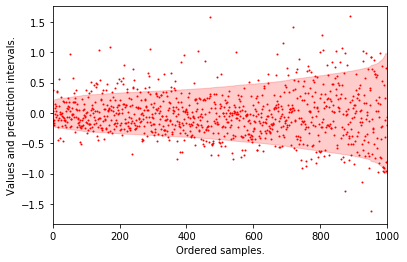

In [17]:
import matplotlib.pyplot as plt
plt.plot(y_true_all, "ro",  markersize=1)
plt.fill_between(
    np.arange(len(upper)), lower, upper, alpha=0.2, color="r",
    label="Pred. interval")
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")
plt.xlim([0, 1000])
plt.show()

As can be seen, we obtained valid coverage.

### Asymmetric nonconformity score 

The nonconformity score function `QuantileRegErrFunc` treats the left and right tails symmetrically, but if the error distribution is significantly skewed, one may choose to treat them asymmetrically. This can be done by replacing `QuantileRegErrFunc` with `QuantileRegAsymmetricErrFunc`, as implemented in the following cell.

In [18]:
from nonconformist.nc import QuantileRegAsymmetricErrFunc

# define QRF model
quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                           fit_params=None,
                                                           quantiles=quantiles_forest,
                                                           params=params_qforest)
        
# define the CQR object
nc = RegressorNc(quantile_estimator, QuantileRegAsymmetricErrFunc())

# run CQR procedure
y_lower, y_upper = helper.run_icp(nc, x_train, y_train, x_test, idx_train, idx_cal, alpha)

# compute and print average coverage and average length
coverage_cp_qforest, length_cp_qforest = helper.compute_coverage(y_test,
                                                                 y_lower,
                                                                 y_upper,
                                                                 alpha,
                                                                 "Asymmetric CQR Random Forests")

Asymmetric CQR Random Forests: Percentage in the range (expecting 90.00): 81.897386
Asymmetric CQR Random Forests: Average length: 1.024932


<h2> Plot the prediction intervals and the original target values </h2>

In [19]:
interval = y_upper - y_lower
sort_ind = np.argsort(interval)
y_true_all = y_test[sort_ind]
upper = y_upper[sort_ind]
lower = y_lower[sort_ind]
mean = (upper + lower) / 2

# Center such that the mean of the prediction interval is at 0.0
y_true_all -= mean
upper -= mean
lower -= mean

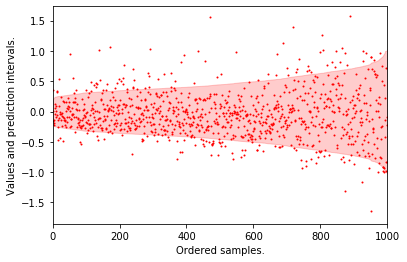

In [20]:
import matplotlib.pyplot as plt
plt.plot(y_true_all, "ro",  markersize=1)
plt.fill_between(
    np.arange(len(upper)), lower, upper, alpha=0.2, color="r",
    label="Pred. interval")
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")
plt.xlim([0, 1000])
plt.show()

Above, we also obtained valid coverage.


## CQR neural net

In what follows we will use neural network as the underlying quantile regression method. Below, we set the hyper-parameters of the CQR neural network method.

In [10]:
import torch
import random
import numpy as np
np.warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

seed = 1

output_column = 'LE_bowen_corr_mm'

random_state_train_test = seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
# desired miscoverage error
alpha = 0.1

# desired quanitile levels
quantiles = [0.05, 0.95]

# used to determine the size of test set
test_ratio = 0.2

# name of dataset
dataset_base_path = "/apps/data/Library_Daily_Albedo_NDVI_LST_Cleaned.csv"
dataset_name = "library_reg_split"

# load the dataset
X, y, df = GetDataset(dataset_name, dataset_base_path)

# divide the dataset into test and train based on the test_ratio parameter
x_train, x_test, y_train, y_test =train_test_split(X,
                                                    y,
                                                    test_size=test_ratio,
                                                    random_state=random_state_train_test)
# reshape the data
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

# compute input dimensions
n_train = x_train.shape[0]
in_shape = x_train.shape[1]

# display basic information
print("Dataset: %s" % (dataset_name))
print("Dimensions: train set (n=%d, p=%d) ; test set (n=%d, p=%d)" % 
      (x_train.shape[0], x_train.shape[1], x_test.shape[0], x_test.shape[1]))

(5123, 51)
checking null values in the whole dataset
False
Index(['Date', 'Site', 'Month_1', 'Month_2', 'Month_3', 'Month_4',
       'Vegetation_1', 'Vegetation_2', 'Vegetation_3', 'WS', 'WS-1', 'WS-2',
       'WS-3', 'WS-4', 'WS-5', 'RH', 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5',
       'TA', 'TA-1', 'TA-2', 'TA-3', 'TA-4', 'TA-5', 'LE_bowen_corr_mm',
       'Eeflux_LST', 'Eeflux_LST-1', 'Eeflux_LST-2', 'Eeflux_LST-3',
       'Eeflux_LST-4', 'Eeflux_LST-5', 'Eeflux_NDVI', 'Eeflux_NDVI-1',
       'Eeflux_NDVI-2', 'Eeflux_NDVI-3', 'Eeflux_NDVI-4', 'Eeflux_NDVI-5',
       'Eeflux_Albedo', 'Eeflux_Albedo-1', 'Eeflux_Albedo-2',
       'Eeflux_Albedo-3', 'Eeflux_Albedo-4', 'Eeflux_Albedo-5', 'Site_1',
       'Site_2', 'Site_3', 'Site_4', 'Site_5'],
      dtype='object')
Dataset: library_reg_split
Dimensions: train set (n=4098, p=48) ; test set (n=1025, p=48)


In [11]:
# divide the data into proper training set and calibration set
idx = np.random.permutation(n_train)
n_half = int(np.floor(n_train/2))
idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

# zero mean and unit variance scaling 
scalerX = StandardScaler()
scalerX = scalerX.fit(x_train[idx_train])

# scale
x_train = scalerX.transform(x_train)
x_test = scalerX.transform(x_test)

# scale the labels by dividing each by the mean absolute response
mean_y_train = np.mean(np.abs(y_train[idx_train]))
y_train = np.squeeze(y_train)/mean_y_train
y_test = np.squeeze(y_test)/mean_y_train

In [12]:
#####################################################
# Neural network parameters
# (See AllQNet_RegressorAdapter class in helper.py)
#####################################################

# pytorch's optimizer object
nn_learn_func = torch.optim.Adam

# number of epochs
epochs = 1000

# learning rate
lr = 0.0005

# mini-batch size
batch_size = 64

# hidden dimension of the network
hidden_size = 64

# dropout regularization rate
dropout = 0.1

# weight decay regularization
wd = 1e-6

# Ask for a reduced coverage when tuning the network parameters by 
# cross-validataion to avoid too concervative initial estimation of the 
# prediction interval. This estimation will be conformalized by CQR.
quantiles_net = [0.1, 0.9]

We now turn to invoke the CQR procedure. The class `AllQNet_RegressorAdapter` defines the underlying neural network estimator. Just as before, `RegressorNc` defines the CQR objecct, which uses `QuantileRegErrFunc` as the nonconformity score. The function `run_icp` returns the conformal band, computed on test data. Lastly, we compute the average coverage and length using `compute_coverage`.

In [13]:
from cqr import helper
from nonconformist.nc import RegressorNc
from nonconformist.nc import QuantileRegErrFunc

# define quantile neural network model
quantile_estimator = helper.AllQNet_RegressorAdapter(model=None,
                                                     fit_params=None,
                                                     in_shape=in_shape,
                                                     hidden_size=hidden_size,
                                                     quantiles=quantiles_net,
                                                     learn_func=nn_learn_func,
                                                     epochs=epochs,
                                                     batch_size=batch_size,
                                                     dropout=dropout,
                                                     lr=lr,
                                                     wd=wd,
                                                     test_ratio=cv_test_ratio,
                                                     random_state=cv_random_state,
                                                     use_rearrangement=False)

# define a CQR object, computes the absolute residual error of points 
# located outside the estimated quantile neural network band 
nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# run CQR procedure
y_lower, y_upper = helper.run_icp(nc, x_train, y_train, x_test, idx_train, idx_cal, alpha)

# compute and print average coverage and average length
coverage_cp_qnet, length_cp_qnet = helper.compute_coverage(y_test,
                                                           y_lower,
                                                           y_upper,
                                                           alpha,
                                                           "CQR Neural Net")

CQR Neural Net: Percentage in the range (expecting 90.00): 91.512195
CQR Neural Net: Average length: 0.998255


<h2> Plot the prediction intervals and the original target values </h2>

In [14]:
interval = y_upper - y_lower
sort_ind = np.argsort(interval)
y_true_all = y_test[sort_ind]
upper = y_upper[sort_ind]
lower = y_lower[sort_ind]
mean = (upper + lower) / 2

# Center such that the mean of the prediction interval is at 0.0
y_true_all -= mean
upper -= mean
lower -= mean

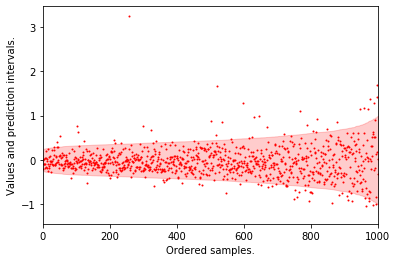

In [15]:
import matplotlib.pyplot as plt
plt.plot(y_true_all, "ro",  markersize=1)
plt.fill_between(
    np.arange(len(upper)), lower, upper, alpha=0.2, color="r",
    label="Pred. interval")
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")
plt.xlim([0, 1000])
plt.show()

Above, we can see that the prediction interval constructed by CQR Neural Net is also valid. Notice the difference in the average length between the two methods (CQR Neural Net and CQR Random Forests). 

## CQR neural net with rearrangement

Crossing quantiles is a longstanding problem in quantile regression. This issue does not affect the validity guarantee of CQR as it holds regardless of the accuracy or choice of the quantile regression method. However, this may affect the effeciency of the resulting conformal band.

Below we use the rearrangement method [3] to bypass the crossing quantile problem. Notice that we pass `use_rearrangement=True` as an argument to `AllQNet_RegressorAdapter`.

[3] Chernozhukov Victor, Iván Fernández‐Val, and Alfred Galichon. “Quantile and probability curves without crossing.” Econometrica 78, no. 3 (2010): 1093-1125.

The quantile crossing problem, is that the conditional quantile curves x→̂Q(u|x) may cross for different values of u

In [16]:
# define quantile neural network model, using the rearrangement algorithm
quantile_estimator = helper.AllQNet_RegressorAdapter(model=None,
                                                     fit_params=None,
                                                     in_shape=in_shape,
                                                     hidden_size=hidden_size,
                                                     quantiles=quantiles_net,
                                                     learn_func=nn_learn_func,
                                                     epochs=epochs,
                                                     batch_size=batch_size,
                                                     dropout=dropout,
                                                     lr=lr,
                                                     wd=wd,
                                                     test_ratio=cv_test_ratio,
                                                     random_state=cv_random_state,
                                                     use_rearrangement=True)

# define the CQR object, computing the absolute residual error of points 
# located outside the estimated quantile neural network band 
nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# run CQR procedure
y_lower, y_upper = helper.run_icp(nc, x_train, y_train, x_test, idx_train, idx_cal, alpha)

# compute and print average coverage and average length
coverage_cp_re_qnet, length_cp_re_qnet = helper.compute_coverage(y_test,
                                                                 y_lower,
                                                                 y_upper,
                                                                 alpha,
                                                                 "CQR Rearrangement Neural Net")

CQR Rearrangement Neural Net: Percentage in the range (expecting 90.00): 91.414634
CQR Rearrangement Neural Net: Average length: 1.004712


<h2> Plot the prediction intervals and the original target values </h2>

In [17]:
interval = y_upper - y_lower
sort_ind = np.argsort(interval)
y_true_all = y_test[sort_ind]
upper = y_upper[sort_ind]
lower = y_lower[sort_ind]
mean = (upper + lower) / 2

# Center such that the mean of the prediction interval is at 0.0
y_true_all -= mean
upper -= mean
lower -= mean

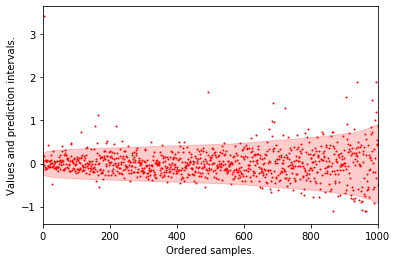

In [18]:
import matplotlib.pyplot as plt
plt.plot(y_true_all, "ro",  markersize=1)
plt.fill_between(
    np.arange(len(upper)), lower, upper, alpha=0.2, color="r",
    label="Pred. interval")
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")
plt.xlim([0, 1000])
plt.show()